# Identifying and Tracking Solar Magnetic Flux Elements with Deep Learning

###### Experement and Paper from NJIT Haodi Jiang,1, 2 Jiasheng Wang,1, 3, 4 Chang Liu,1, 3, 4 Ju Jing,1, 3, 4 Hao Liu,1, 2 Jason T. L. Wang,1, 2 and Haimin Wang1, 3, 

#### The identification of surface magnetic elements is useful in deriving satistical parameters of local and global solar dynamo, this allows for sophisticated analyses of solar activity. The ML algorithm was created to identify and track solar magnetic flux elements that are observed in vector magnetograms in SWAMIS (South West Automatic Magnetic Identification Suite)
* When looking at images of magnetic features they are defined as a visually identifiable part of an image. They are clump of magnetic flux or a blob in magnetograms.
* **SWAMIS:** SouthWest Automatic Magnetic Identification Suite which is a popular tool for feature tracking. There are 5 Steps to how it works
    1. Feature discrimination for each frame
    2. Feature identification within a frame
    3. feature association across frames
    4. occasional noise filtering
    5. event detection
* Magnetic events are boadly classified as death and birth
* The Algorithm can dected 3 different types of events
    1. Disappearance and Appearence
        * **Disappearance:** The end of a single unipolar magnetic feature that "fades away" to nothing in the absence of nearby features across 2 frames.
        * **Appearence:** The origin of a single unipolar feature where the unipolar feature does not exist in the previous frame.
    2. Merging and Splitting
        * **Merging:** The combination fo 2 or more like-sign features into a single magnetic feature.
        * **Splitting:** The breakup of a single magnetic feature into the least 2 like-sign features, this is where the total flux of all child featurs is roughtly the same as the parent feature.
    3. Cancellation and Emergence.
        * **Cancellation:** The demise of a magnetic feature that collides with one or more opposite-sign features, resulting in the demise of these features or an alive feature carrying the remaining flux.
        * **Emergence:** The appearance of opposite-sign features in a nearly flux-conserving manner.

### Import Library's

In [3]:
import keras as keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans
import matplotlib.image as mpimg
import matplotlib.colors as mpcolor
import os
import cv2

from astropy.io import fits
from keras.preprocessing.image import ImageDataGenerator
from magnetic_tracking import magnetic_tracking
from statistics_analysis import analysis

%matplotlib inline

## Data
#### Data was used was 2 different observations.
1. Conducted by Near InfraRead Imaging Spectopolarimeter (NIRIS) of the 1.6 m Goode Solar Telescope (GST) at the Big Bear Solar Observatory (BBSO).
    * The collection contained obervations of magnetic olarity inversion region in NOAA AR 12665 during ~20:16 - 22:42 UT on 2017 of July 13. Data included spectro-polarimetric observations of a full set of Stokes mesasurements at the FE I 1564.8 nm line by NIRIS with a FOV of 80"
2. Conducted with a clear seeing condition, BBSO/GST achieved diffraction limited imaging during ~16:17 - 22:17 UT on 2018 June 07.
    * Data was multi-wavelength observations that revealed detailed structural and evolutionary properties of small scale magnetic polarities in quiescent solar regions at north of the disk center. Data also included were images taken by the GST's NIRIS. Magnetograms were ten aligned based on sunspot and plage featrures with alignment accuracy within 0".3.

## Data Set-up
1. Apply SWAMIS with the downhill option to the 196 training magnetograms to get 196 masks. These images, including the magnetograms and masks, are converted to 8-bit grayscale images of 720x720 pixels (Input). The Pixels in the masks belong to three classes.
    1. **White:** Positive magnetic flux with a label of 1
    2. **Black:** Negative magnetic flux with a label of -1
    3. **Gray:** Non-significatnt flux with a label of 0
    * These images are used to **train**.

intgr_180607_161752.fts


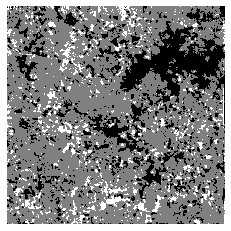

intgr_180607_161904.fts


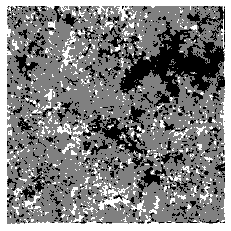

In [8]:
image_location = './Data/example_of_preproccess_data/3_class/'
for name in os.listdir(image_location):
    print(name)
    fits_file = fits.open(image_location + name)
    fits_data = fits_file[0].data
    plt.axis('off')
    plt.imshow(fits_data, cmap='gray', interpolation='none')
    plt.show()

2. During **Preprocessing** we convert the 196 three-class masks obtained from SWAMIS to 196 two-class (Binary) Masks by
    1. Changing the **Non-significant** flux regions from 0 to 1
    2. Change both the **Positive and Negative** flux regions to significant flux regions with label -1.
    * This images are **labels**

In [10]:
image_location_mask = './Data/example_of_preproccess_data/2_class/'
def pre_processing(image_location, image_location_mask):
    for name in os.listdir(input_3_class_mask_path):
        print(name)
        fits_file = fits.open(input_3_class_mask_path + name)
        fits_data = fits_file[0].data
        fits_data = np.flipud(fits_data)
        height, width = fits_data.shape

        output_image = np.empty([height, width])
        output_image.fill(np.nan)
        for i in range(height):
            for j in range(width):
                if fits_data[i][j] == 0:
                    output_image[i][j] = 255
                else:
                    output_image[i][j] = 0
        cv2.imwrite('{}{}.png'.format(output_path, name[:-4]), output_image)

intgr_180607_161752.png


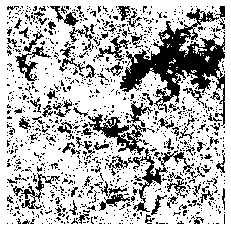

intgr_180607_161904.png


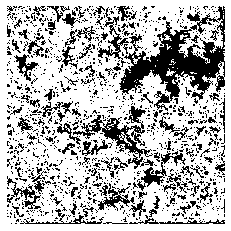

In [18]:
for name in os.listdir(image_location_mask):
    print(name)
    location = image_location_mask + name
    image = mpimg.imread(location)
    plt.axis('off')
    image = np.flipud(image)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.show()

3. The Deep learning model needs a large amount of data in order to train successfully, the model uses *Image Data Generator* from Keras to perform data augmentation. To achive this the algorithm works as such.
    1. **Shifting Image:** Move all pixels of the image horizontally or vertically while keeping the dimensions of the image the same.
    2. **Rotating Image:** Rotate the image *clockwise* by a given number of degrees from 0 -> 360.
    3. **Flipping Image:** Reverse the *Rows or Columns* of the pixels in the image.
    4. **Scaling Image:** Randomly Zoom the image in and either add new pixel values around the image or interpolate pixel values in the image.

In [2]:
def train_generator(batch_size, train_path, image_folder, mask_folder):

    data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes=[image_folder],
        class_mode=None,
        color_mode="grayscale",
        target_size=(720,720),
        batch_size=batch_size,
        seed=1)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes=[mask_folder],
        class_mode=None,
        color_mode="grayscale",
        target_size=(720,720),
        batch_size=batch_size,
        seed=1)
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        img,mask = adjust_data(img, mask)
        yield img, mask

In [3]:
def adjust_data(img, mask):
    if np.max(img) > 1:
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return img, mask

## Model

#### **U-Net:** This is a U-Shaped CNN for fast and acurate image segmentation

### **Input:** This will have one neuron with a 720x720 image input with a channel of 1

In [4]:
inputs = keras.Input(shape=(720, 720, 1))

### **Encoder 1:** Will have 32 Neurons kernel will have the size of 3x3 with an activation function of ReLU with batch normalization at the end of the encoder we have a pooling with a size of 2x2 and a dropout rate of 50% this is connected to decoder 4

In [5]:
e1 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
e1_bn = keras.layers.BatchNormalization()(e1)
e1 = keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(e1_bn)
e1_bn = keras.layers.BatchNormalization()(e1)
e1_pool = keras.layers.MaxPooling2D(pool_size=(2,2))(e1_bn)
e1_dropout = keras.layers.Dropout(0.5)(e1_pool)

### **Encoder 2:** Will have 64 Neurons kernel will have the size of 3x3 with an activation function of ReLU with batch normalization at the end of the encoder we have a pooling with a size of 2x2 and a dropout rate of 50% this is connected to decoder 3

In [6]:
e2 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(e1_dropout)
e2_bn = keras.layers.BatchNormalization()(e2)
e2 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(e2_bn)
e2_bn = keras.layers.BatchNormalization()(e2)
e2_pool = keras.layers.MaxPooling2D(pool_size=(2,2))(e2_bn)
e2_dropout = keras.layers.Dropout(0.5)(e2_pool)

### **Encoder 3:** Will have 128 Neurons kernel will have the size of 3x3 with an activation function of ReLU with batch normalization at the end of the encoder we have a pooling with a size of 2x2 and a dropout rate of 50% this is connected to decoder 2

In [7]:
e3 = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(e2_dropout)
e3_bn = keras.layers.BatchNormalization()(e3)
e3 = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(e3_bn)
e3_bn = keras.layers.BatchNormalization()(e3)
e3_pool = keras.layers.MaxPooling2D(pool_size=(2,2))(e3_bn)
e3_dropout = keras.layers.Dropout(0.5)(e3_pool)

### **Encoder 4:** Will have 256 Neurons kernel will have the size of 3x3 with an activation function of ReLU with batch normalization at the end of the encoder we have a pooling with a size of 2x2 and a dropout rate of 50% this is connected to decoder 1

In [8]:
e4 = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(e3_dropout)
e4_bn = keras.layers.BatchNormalization()(e4)
e4 = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(e4_bn)
e4_bn = keras.layers.BatchNormalization()(e4)
e4_pool = keras.layers.MaxPooling2D(pool_size=(2,2))(e4_bn)
e4_dropout = keras.layers.Dropout(0.5)(e4_pool)

### **Bottle Neck:** Will have 256 Neurons kernel will have the size of 3x3 with an activation function of ReLU with batch normalization at the end of the encoder

In [9]:
bn = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(e4_dropout)
bn_bn = keras.layers.BatchNormalization()(bn)

### **Decoder 1:** Will have 256 Neurons kernel will have the size of 3x3 with an activation function of ReLU with a 2 Dimentional Up Sampling Layer with a size of 2x2 and a concatination from Encoder 4 on the 3rd axis. Dropout of 50%. We will then have 2 layers of 2 Dimenstional Convolutional nuerons with 256 Nurons with a kernal size of 3x3 and Batch Normalization between each convolutional layer

In [10]:
d1 = keras.layers.Conv2D(256, (2,2), activation='relu', padding='same', kernel_initializer='he_normal')(keras.layers.UpSampling2D(size=(2,2))(bn_bn))
d1_merge = keras.layers.concatenate([e4, d1], axis=3)
d1_drop = keras.layers.Dropout(0.5)(d1_merge)
d1 = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(d1_drop)
d1_bn = keras.layers.BatchNormalization()(d1)
d1 = keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(d1_bn)
d1_bn = keras.layers.BatchNormalization()(d1)

### **Decoder 2:** Will have 128 Neurons kernel will have the size of 3x3 with an activation function of ReLU with a 2 Dimentional Up Sampling Layer with a size of 2x2 and a concatination from Encoder 3 on the 3rd axis. Dropout of 50%. We will then have 2 layers of 2 Dimenstional Convolutional nuerons with 128 Nurons with a kernal size of 3x3 and Batch Normalization between each convolutional layer

In [11]:
d2 = keras.layers.Conv2D(128, (2,2), activation='relu', padding='same', kernel_initializer='he_normal')(keras.layers.UpSampling2D(size=(2,2))(d1_bn))
d2_merge = keras.layers.concatenate([e3, d2], axis=3)
d2_drop = keras.layers.Dropout(0.5)(d2_merge)
d2 = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(d2_drop)
d2_bn = keras.layers.BatchNormalization()(d2)
d2 = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(d2_bn)
d2_bn = keras.layers.BatchNormalization()(d2)

### **Decoder 3:** Will have 64 Neurons kernel will have the size of 3x3 with an activation function of ReLU with a 2 Dimentional Up Sampling Layer with a size of 2x2 and a concatination from Encoder 2 on the 3rd axis. Dropout of 50%. We will then have 2 layers of 2 Dimenstional Convolutional nuerons with 64 Nurons with a kernal size of 3x3 and Batch Normalization between each convolutional layer

In [12]:
d3 = keras.layers.Conv2D(64, (2,2), activation='relu', padding='same', kernel_initializer='he_normal')(keras.layers.UpSampling2D(size=(2,2))(d2_bn))
d3_merge = keras.layers.concatenate([e2, d3], axis=3)
d3_drop = keras.layers.Dropout(0.5)(d3_merge)
d3 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(d3_drop)
d3_bn = keras.layers.BatchNormalization()(d3)
d3 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(d3_bn)
d3_bn = keras.layers.BatchNormalization()(d3)

### **Decoder 4:** Will have 64 Neurons kernel will have the size of 3x3 with an activation function of ReLU with a 2 Dimentional Up Sampling Layer with a size of 2x2 and a concatination from Encoder 1 on the 3rd axis. Dropout of 50%. We will then have 2 layers of 2 Dimenstional Convolutional nuerons with 64 Nurons with a kernal size of 3x3 and Batch Normalization between each convolutional layer

In [13]:
d4 = keras.layers.Conv2D(64, (2,2), activation='relu', padding='same', kernel_initializer='he_normal')(keras.layers.UpSampling2D(size=(2,2))(d3_bn))
d4_merge = keras.layers.concatenate([e1, d4], axis=3)
d4_drop = keras.layers.Dropout(0.5)(d4_merge)
d4 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(d4_drop)
d4_bn = keras.layers.BatchNormalization()(d4)
d4 = keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(d4_bn)
d4_bn = keras.layers.BatchNormalization()(d4)

## **Output:** Will be a 2 dimentional convolutional layer with 1 neuron with a kernal size of 1x1 with an acitvation function of Sigmoid.

In [14]:
outputs = keras.layers.Conv2D(1, (1,1), activation='sigmoid')(d4_bn)

In [15]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 720, 720, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 720, 720, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 720, 720, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 720, 720, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

## Training
* When Training the model will be using 1 epoch with 10,000 Iterations.
    * Each Iteration, the model will randomly select one of the 196 training magnetograms and its binary mask. This will then feed them to the *Image Data Generator* to generate a synthetic magnetogram and binary mask
    * Since there are 10,000 Iterations there will be 10,000 Synthetic magnetorgrams and binary masks that are generated through the data augmentation process.

In [17]:
train_gen = train_generator(1, './data/', 'image', 'label')

In [18]:
model_checkpoint = keras.callbacks.ModelCheckpoint('solar_research_test_1.hdf5', monitor='loss', verbose=1, save_best_only=True)

In [19]:
model.fit_generator(train_gen, steps_per_epoch=10000, epochs=1, verbose=1, callbacks=[model_checkpoint])

Found 196 images belonging to 1 classes.
Found 196 images belonging to 1 classes.


C:\Users\feren\anaconda3\envs\Research\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


10000/10000 [==============================] - 3459s 344ms/step - loss: 0.1207 - accuracy: 0.9480

Epoch 00001: loss improved from inf to 0.12065, saving model to solar_research_test_1.hdf5


## Testing
* Model weights is loaded from the *Model Checkpoint* that was created during the training process.

In [17]:
model.load_weights('./solar_research_test_1.hdf5')

* The image that is submitted is converted to a 8-bit grayscale image of 720x720 pixels, this is feed into the trained deep learning model.

In [18]:
def test_generator(test_path, target_size=(720,720)):
    for name in os.listdir(test_path):
        img = io.imread(os.path.join(test_path, name), as_gray=True)
        img = img / 255
        img = trans.resize(img, target_size)
        img = np.reshape(img, img.shape + (1,))
        img = np.reshape(img, (1,) + img.shape)
        yield img

In [19]:
test_gen = test_generator('./Data/test/')

* The model will then predict a 2-class mask, this is containing **Non-Significant** flux regions with a label of 1 (White), and **Significant** flux regions with label -1 (Black)

In [20]:
results = model.predict_generator(test_gen, 3, verbose=1)

C:\Users\feren\anaconda3\envs\Research\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3/3 [==============================] - 4s 43ms/step


## Post Processing
* This will convert the predicted 2-Class binary mask back to a 3-Class mask.
    1. **Non-Significant:** This had a label of 1 this will be changed back to 0 (original)
    2. **Significant:** This had a label of -1, Use the information of radial components in the vertical magnetic field image.
        * Radial Components are *perpendicular* to the plane of the sun, 
        * **Reconstruct positive and negative magnetic flux regions:** For each pixel *x* in the *significant flux regions in predicted binary mask* check the magnetic strength of the pixel *y* at *x*'s the corresponding location.
        1. If *y* is **greater** than 150 G
            * Set *x* as *positive magnetic flux* change the label of this pixel from -1 to 1 (White - Positive)
        2. If *y* is **smaller** than -150 G
            * Set *x* as *negative magnetic flux* and leave the label -1 (Black - Negative)
        3. If *y* is **greater** than -150 G and **smaller** than -150 G
            * Set *x* as a *non-significant flux* and change label from -1 to 0 (Gray - Non-significant)

In [21]:
def post_processing():
    """read corresponding predicted_mask field data"""
    predicted_mask_2_path = 'results/predicted_mask/'
    output_mask_2_path = 'results/processed_data_for_tracking/mask_2_class/'
    output_mask_3_path = 'results/processed_data_for_tracking/mask_3_class/'
    fitz_path = 'results/processed_data_for_tracking/fits/'

    predicted_mask_2_files_list = os.listdir(predicted_mask_2_path)

    file_index = 0
    for name in os.listdir(fitz_path):

        fits_file = fits.open(fitz_path+name)
        fits_data = fits_file[0].data
        fits_data = np.flipud(fits_data)
        height, width = fits_data.shape
        fits_file.close()

        image_name = '{}{}'.format(predicted_mask_2_path,predicted_mask_2_files_list[file_index])
        file_index += 1
        img = cv2.imread(image_name, -1)

        output_image = np.empty([height, width])
        output_image.fill(np.nan)

        for i in range(height):
            for j in range(width):
                if img[i][j] == 255:
                    output_image[i][j] = 127
                elif img[i][j] == 0:
                    if fits_data[i][j] < -150:
                        output_image[i][j] = 0
                    elif fits_data[i][j] > 150:
                        output_image[i][j] = 255
                    else:
                        output_image[i][j] = 127
                else:
                    if fits_data[i][j] < -150:
                        output_image[i][j] = 0
                    elif fits_data[i][j] > 150:
                        output_image[i][j] = 255
                    else:
                        output_image[i][j] = 127
        mask_3 = output_image

        # remove connection
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                p = mask_3[i][j]
                p1 = mask_3[i - 1][j - 1]
                p2 = mask_3[i - 1][j]
                p3 = mask_3[i - 1][j + 1]
                p4 = mask_3[i][j - 1]
                p5 = mask_3[i][j + 1]
                p6 = mask_3[i + 1][j - 1]
                p7 = mask_3[i + 1][j]
                p8 = mask_3[i + 1][j + 1]
                if p != 127:
                    if p == 255:
                        if 0 in [p1, p2, p3, p4, p5, p6, p7, p8]:
                            mask_3[i][j] = 127
                    elif p == 0:
                        if 255 in [p1, p2, p3, p4, p5, p6, p7, p8]:
                            mask_3[i][j] = 127

        cv2.imwrite(output_mask_3_path+'mask_3_class_{0:03}.png'.format(file_index), mask_3)

        for i in range(height):
            for j in range(width):
                if mask_3[i][j] == 127:
                    mask_3[i][j] = 255  # 0 black,   for object detection forgroud should be white , backgroud should black
                else:
                    mask_3[i][j] = 0  # 255 white
        cv2.imwrite(output_mask_2_path + 'mask_2_class_{0:03}.png'.format(file_index), mask_3)
    # print('Postprocess done')

In [22]:
def plot_mask():
    predicted_mask_path = 'results/processed_data_for_tracking/mask_3_class/'
    testing_image_path = 'data/magnetic/test/'
    output_path = 'results/demo_plots/'

    img = mpimg.imread(testing_image_path + 'frame_1.png')
    mask = mpimg.imread(predicted_mask_path + 'mask_3_class_001.png')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax[0].imshow(img, cmap='gray', extent=(413, 473, -204, -144))
    ax[0].set_xlabel("E-W (arcsec)", fontsize=10)
    ax[0].set_ylabel("S-N (arcsec)", fontsize=10)
    ax[0].set_title('Testing Magnetogram', fontsize=12)

    ax[1].imshow(mask, cmap='gray', extent=(413, 473, -204, -144))
    ax[1].set_xlabel("E-W (arcsec)", fontsize=10)
    ax[1].set_ylabel("S-N (arcsec)", fontsize=10)
    ax[1].set_title('SolarUnet Mask', fontsize=12)

    plt.savefig(output_path+'demo_3_class_masks.png', bbox_inches='tight')
    plt.show()

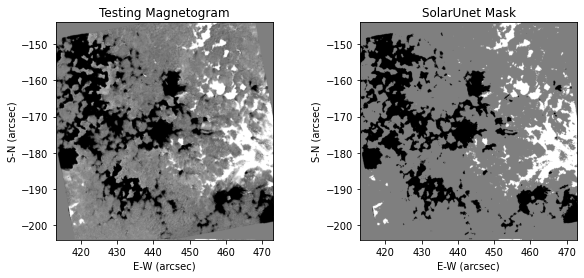

In [31]:
post_processing()
plot_mask()

## Tracking
* To group all adjacent segments in the *positive magnetic flux regions and negative magnetic flux regions* if their piexels in edge or corners touch eachother. Filter out those magnetic features whose sizes are smaller than user-determined threshold.
* Assign each of the remaning features a label number and highlight the features with a different bordering colors.
* Consider the association of features (magnetic flux elements) across different frames to perform event detection.

In [33]:
magnetic_tracking('./results/processed_data_for_tracking/', './results/tracking_results/')

============magnetic tracking start============
-----------------process frame 1------------------
-----------------process frame 2------------------
-----------------process frame 3------------------
-----------------Done------------------


In [37]:
def plot_tracking_results():
    extent_value = (413, 473, -204, -144)
    input_path = 'results/tracking_results/'
    output_path = 'results/demo_plots/'
    img_list = []
    for name in os.listdir(input_path):
        img = mpimg.imread(input_path + name)
        img_list.append(img)

    img1 = img_list[0]
    img2 = img_list[1]
    img3 = img_list[2]
    my_map = 'gray'
    fontsize = 10
    norm = mpcolor.Normalize(vmin=-500, vmax=500)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    im = ax[0].imshow(img1, cmap=my_map, extent=extent_value, norm=norm)
    ax[0].set_xlabel("E-W (arcsec)", fontsize=fontsize)
    ax[0].set_ylabel("S-N (arcsec)", fontsize=fontsize)
    ax[0].set_title('frame-1', x=0.9, y=0, fontsize=fontsize)

    ax[1].imshow(img2, cmap=my_map, extent=extent_value, norm=norm)
    ax[1].set_xlabel("E-W (arcsec)", fontsize=fontsize)
    ax[1].set_ylabel("S-N (arcsec)", fontsize=fontsize)
    ax[1].set_title('frame-2', x=0.9, y=0, fontsize=fontsize)

    ax[2].imshow(img3, cmap=my_map, extent=extent_value, norm=norm)
    ax[2].set_xlabel("E-W (arcsec)", fontsize=fontsize)
    ax[2].set_ylabel("S-N (arcsec)", fontsize=fontsize)
    ax[2].set_title('frame-3', x=0.9, y=0, fontsize=fontsize)

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.3, hspace=0.15)
    cax = plt.axes((0.92, 0.168, 0.014, 0.665))
    cb = fig.colorbar(im, cax=cax, norm=norm)
    cb.ax.tick_params(labelsize=fontsize)
    cb.set_label('Gauss', fontsize=fontsize)

    plt.savefig(output_path+'demo_tracking_result.png', bbox_inches='tight')
    plt.show()

In [38]:
def plot_mask():
    predicted_mask_path = 'results/processed_data_for_tracking/mask_3_class/'
    testing_image_path = 'data/magnetic/test/'
    output_path = 'results/demo_plots/'

    img = mpimg.imread(testing_image_path + 'frame_1.png')
    mask = mpimg.imread(predicted_mask_path + 'mask_3_class_001.png')
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax[0].imshow(img, cmap='gray', extent=(413, 473, -204, -144))
    ax[0].set_xlabel("E-W (arcsec)", fontsize=10)
    ax[0].set_ylabel("S-N (arcsec)", fontsize=10)
    ax[0].set_title('Testing Magnetogram', fontsize=12)

    ax[1].imshow(mask, cmap='gray', extent=(413, 473, -204, -144))
    ax[1].set_xlabel("E-W (arcsec)", fontsize=10)
    ax[1].set_ylabel("S-N (arcsec)", fontsize=10)
    ax[1].set_title('SolarUnet Mask', fontsize=12)

    plt.savefig(output_path+'demo_3_class_masks.png', bbox_inches='tight')
    plt.show()

# Output Data
### **Main Algorithm**
1. If there is a magnetic flux element in the next frame such that the original magnetic flux element in the current frame is approximately equal to the magnetic flux element in the next frame.
    * Highlight the original magnetic flux element boarder **yellow** this is **positive** if the original magnetic flux element is **negative** then highlight boarder color **green**. (Exit)
2. Otherwise find all magnetic featrues in current frame. Group these featrues whos signs are the same.
3. Go to *Merging Algorithm* to check weather the original magnetic flux element and the featrues meet the merging criterion.
    * **Yes**: Perform the merging using *Merging Algorithm* and then exit Main
    * **No**: indicate the current magnetic flux is not involved in the merging event.
4. Go to *Cancellation Algorithm* to check weather the current magnetic flux element in the opposite group meet the cancellation critrion.
    * **Yes**: Perform the cancellation using *Cancellation Algorithm* and Exit main.
    * **No**: indicate the current magnetic flux element is not involved in a cancellation event.
5. If The current Magnetic flux element is not involved in a merging event and the current magnetic flux element is not involved in the cancellation event. Indicate that the current magnetic flux disappears and highlight the boarding color **purple**.

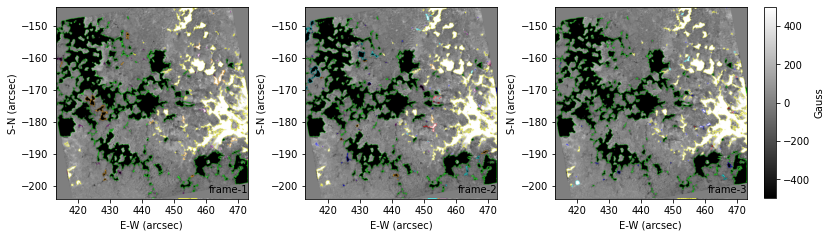

In [39]:
plot_tracking_results()

## Analysis
1. Compare the *feature size and distribution* on the testing images.
    * **Blue:** Feature size
    * **Orange:** SolarUNet
    * Results of SolarUnet and SWAMIS have significant difference when *p* <= 0.05
2. Caluclated Flux using formula and compaires flux distributions of SWAMIS and SolarUnet.

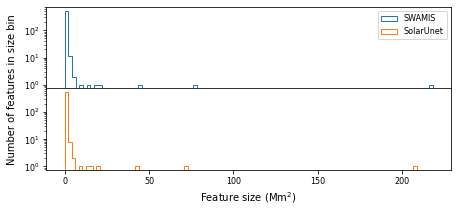

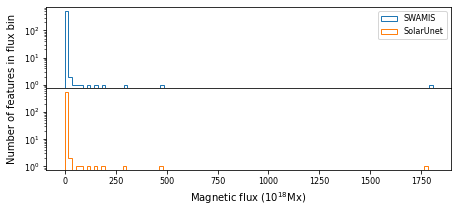

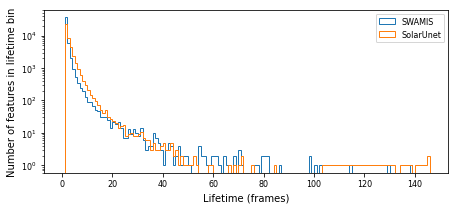

In [40]:
analysis()